# Homework - ConvNeXt and all the King's horses


Let's check how ConvNeXt architecture looks like and which training technics were used to make it work

This homework assumes than you have already solved the previous homework.

The homework contains three parts:

1. Implementation of some staff for ConvNeXt network definition
2. Implementation of some other staff for effective training
3. Experiments with model averaging, label smoothing and layer norm


# 1. Prerequesites: dataset and data loaders

We will continue to use Tiny-Imagenet dataset. So let's download it in a way, how we did it in the previous homework.

In [ ]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

In [1]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was already downloaded to './tiny-imagenet-200.zip'. Skip downloading
Extract downloaded dataset to '.'


We will also need some code from the previous homework, that defines training data augmentations and represents validation data as dataset (class `TinyImagenetValDataset` below). Feel free to copy-paste the code from your solution of the previous homework. 

In [1]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [3]:
#!L

train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : copy-paste your transform parameters for color jitter from the previous homework
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.15),
     # you may add any other transforms here but color jitter should be enough
    ]
)

In [4]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


One more block from the previous homework that we will need here (fill free to copy-paste it from your previous solution)

In [5]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([annot[1] for annot in annotations])))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image =  tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

In [6]:
#!L

val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:30<00:00, 325.70it/s]


In [7]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

In [8]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=4)

# 2. ConvNeXt architecture

In [9]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

What are the key differences between resnet-50 and ConvNeXt architectures?
- stem redesign: single conv layer with kernel size 4 and stride 4 instead of combination of conv layer and max pooling (+0.1%)
- stage ratio 1:1:3:1 or 1:1:9:1 (+0.6%)
- depthwise separable convolutions (introduced in ResNeXt) with inverted bottlenecks (introduced in MobileNet v2) (+1.1%)
- some micro design changes: fewer activations, fewer normalization layers, GELU and LN usage (+0.9%)
- replacing strided convolutions in blocks on separate downscale convolutions (+0.5%)
- improved training technics (+2.7%)
  - Longer training (90 -> 300 epochs) 
  - AdamW optimizer, warm-up, cosine scheduler (we will discuss it in seminar 3).
  - Advanced data augmentation techniques: Mixup, Cutmix, RandAugment, Random Erasing (we will discuss it in seminar 3)
  - Regularization schemes: Stochastic Depth, Label Smoothing
  - LayerScale
  - exponential moving average on network weights

<table>
    <tr>
        <td><h3>Architecture</h3></td>
        <td><h3>Improvements</h3></td>
    </tr>
    <tr>
        <td><img src="./convnext_arch.png" alt="drawing" width="500"/></td>
        <td><img src="./convnext_impr.png" alt="drawing" width="500"/></td>
    </tr>
</table>

## 2.1 ConvNeXt block design

Here is how a single block looks like

<img src="./convnext_block.png" alt="drawing" width="200"/>

### 2.1.1 Depthwise convolutions

Depthwise convolutions is the special case of group convolutions. Here is a good illustration of how group convolution works:

<img src="./group_conv.png" alt="drawing" width="500"/>

([image credit](https://cvml-expertguide.net/terms/dl/layers/convolution-layer/grouped-convolution/))

Group convolution takes 4d tensor of shape [N,C,H,W] as input, splits it evenly on K groups (K is hyperparameter; K=4 in image above) along the channel dimension, applies vanilla 2d convolution to each group with their own kernels and then concat the output tensors along the channel dimension.

In depthwise convolution number of groups is equal to the number of input channels C. It is usually followed by "pointwise convolution" - convolution with 1x1 kernel, which changes the number of output channels.

<img src="./dw_conv.png" alt="drawing" width="500"/>

([image credit](https://www.researchgate.net/figure/Depthwise-separable-convolutions_fig1_358585116))

The number of output channels in depthwise convolution by design is greater or equal than number of input channels (why?). For group convolutions the number of output channels could not be less than the number of groups.

Here is how you can implement depthwise convolution 7x7 in pytorch:

In [10]:
n_input_channels = 96
n_output_channels = 192
# TODO: examine nn.Conv2d doc and create depthwise conv layer with 96 input channels, 192 output channels, 7x7 kernel
layer = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=7, groups=96)

parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == (7*7*192 + 192), parameters_size

Note that amount of parameters for kernel is 7x7x192. Vanilla Conv2d would have 7x7x192x96 parameters in kernel under the same settings.

### 2.1.2 LayerNorm and GELU

You are parially familiar with LayerNorm and GELU layers from lecture 2. And we will discuss these layers on lecture 3 and seminar 3. 

What is important to know here is that the authors of ConvNeXt replaced ReLU with GELU and BatchNorm with LayerNorm and got some improvements (+0.1%).

In the experiments section below we will check if LayerNorm really helps in our training setup.

But before we start, let's implement simple wrapper over nn.LayerNorm so than it would work with 4d tensors more like batch norm does. BatchNorm2D expects to work with [N,C,H,W] tensors and normalizes the channel dimension. nn.LayerNorm normalizes the last dimension of the input tensor.

So let's permute dimensions in LayerNorm2d forward() method, apply the standard nn.LayerNorm to the new tensor and permute its dimensions back.

In [11]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        
    def forward(self, x):
        # TODO: YOUR CODE
        # 1. permute tensor dimensions so that channel dim became the last
        # 2. apply self.ln
        # 3. permute tensor dimensions back
        x = x.permute((0, 2, 3, 1))
        x = self.ln(x)
        x = x.permute((0, 3, 1, 2))

        return x

In [12]:
x = torch.rand((2, 5, 4, 3))
layer = LayerNorm2d(5)
out = layer(x)
print(out.size())
assert out.size() == x.size()
parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == 10, parameters_size  # 5 for channel weights and 5 for biases

torch.Size([2, 5, 4, 3])


### 2.1.3 LayerScale

LayerScale is a technique used to force residual branch to work more like residual branch.
<table>
    <tr>
        <td><center><h4>Original residual branch for transformer</h4></center></td>
        <td><center><h4>Residual branch with LayerScale</h4></center></td>
    </tr>
    <tr>
        <td><center><img src="./layer_scale-orig_residual.png" alt="drawing" height="400"/></center></td>
        <td><center><img src="./layer_scale-new_residual.png" alt="drawing" height="400"/></center></td>
    </tr>
</table>

LayerScale downscales residual branch output with some (learnable) weights which are very small at the begining (1e-6 in our experiments and in paper) but can become larger during training.

Scaling is applied to each channel independenly. Here is implementation of the layer:

In [13]:
class LayerScale2d(nn.Module):
    def __init__(self, dim, layer_scale_init_value):
        super().__init__()
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim, 1, 1)), requires_grad=True)
        
    def forward(self, x):
        # YOUR CODE: just scale x on self.gamma
        x = x * self.gamma
        return x

In [14]:
x = torch.rand((2, 5, 4, 3))
layer_scale_init_value = 1e-5
layer = LayerScale2d(5, layer_scale_init_value)
out = layer(x)
assert out.size() == x.size()
assert np.allclose(out.detach().numpy(), x.numpy()*layer_scale_init_value)

In [15]:
x = torch.rand((3, 2, 2))
print(x)
layer_scale_init_value = 2
layer = LayerScale2d(3, layer_scale_init_value)
out = layer(x)
print(out)

tensor([[[0.1492, 0.9906],
         [0.0998, 0.2237]],

        [[0.4285, 0.8853],
         [0.8201, 0.1226]],

        [[0.4651, 0.1025],
         [0.7058, 0.3320]]])
tensor([[[0.2984, 1.9813],
         [0.1996, 0.4475]],

        [[0.8570, 1.7705],
         [1.6402, 0.2453]],

        [[0.9303, 0.2050],
         [1.4115, 0.6640]]], grad_fn=<MulBackward0>)


### 2.1.4 Stochastic Depth

Stochastic depth was introduced in [paper](https://arxiv.org/pdf/1603.09382.pdf) as a way of overfitting reduction. You can think of it as about dropout on residual branches. Block with residual connection with stochastic depth module looks like `y = x + DropPath(ResidualNet(x))` instead of classic `y = x + ResidualNet(x)`

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as it is usually done in `Dropout` layer).

(This layer will be also discussed in seminar dedicated to vision transformers)

In [16]:
#!L

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        # YOUR CODE: generate random tensor, binarize it, cast to x.dtype, multiply x by the mask, 
        # devide the result on keep_prob
        random_tensor = torch.rand(shape)
        mask = random_tensor > self.drop_prob
        mask = mask.type(x.type())
        output = x * mask / keep_prob
        return output

In [17]:
x = torch.rand((3, 2, 2))
print(x)
a = x > 0.3
print(a.type(x.type()))

tensor([[[0.4237, 0.0871],
         [0.8751, 0.3968]],

        [[0.7367, 0.2420],
         [0.1860, 0.5679]],

        [[0.3224, 0.7494],
         [0.7910, 0.9720]]])
tensor([[[1., 0.],
         [1., 1.]],

        [[1., 0.],
         [0., 1.]],

        [[1., 1.],
         [1., 1.]]])


In [18]:
layer = DropPath(0.5)

x = torch.rand((10,5,4,3))

layer.eval()
out = layer(x)
assert out.size() == x.size()
assert (out == x).all()

layer.train()
out = layer(x)
assert out.size() == x.size()
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=1).all(dim=1).all(dim=1)
n_dropped_samples = dropped_samples_mask.to(float).sum()
assert n_dropped_samples > 2 and n_dropped_samples < 8, n_dropped_samples

layer = DropPath(0.1)
out = layer(x)
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=1).all(dim=1).all(dim=1)
scaled_samples_mask = torch.isclose(out, x/0.9).all(dim=1).all(dim=1).all(dim=1)
assert torch.logical_or(dropped_samples_mask, scaled_samples_mask).all()                                                    

### 2.1.5 Putting it all together

Once again, image of ConvNeXt block

<img src="./convnext_block.png" alt="drawing" width="200"/>

The only thing that is not shown on the image is `DropPath` block which should be applied in the end of residual branch just after `LayerScale2d`

We will create `ConvNextBlock` that can operates with `LayerNorm2d` and `BatchNorm2d` depending on parameter `use_bn` and will check what will perform better in our experiments. 

In [19]:
#!L

class ConvNextBlock(nn.Module):
    def __init__(self, dim, drop_rate=0., layer_scale_init_value=1e-6, use_bn=False):
        super().__init__()
        
        # YOUR CODE: define self.depthwise_conv  self.pointwise_conv1 self.pointwise_conv2
        self.depthwise_conv = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=5, padding=2, groups=dim)  # depthwise conv 5x5, padding 2, dim->dim
        
        self.norm = LayerNorm2d(dim) if not use_bn else nn.BatchNorm2d(dim)
        
        self.pointwise_conv1 = nn.Conv2d(in_channels=dim, out_channels=dim*4, kernel_size=1)  # 1x1 conv, dim -> dim*4  YOUR CODE

        self.activation = nn.GELU()
        
        self.pointwise_conv2 = nn.Conv2d(in_channels=dim*4, out_channels=dim, kernel_size=1)  # 1x1 conv, 4*dim -> dim YOUR CODE

        self.layer_scale = LayerScale2d(dim, layer_scale_init_value) if layer_scale_init_value > 0 else nn.Identity()
        self.drop_path = DropPath(drop_rate) if drop_rate is not None and drop_rate > 0. else nn.Identity()

    def forward(self, x):
        input = x
        # YOUR CODE: sequentially apply to x: depthwise_conv + norm + pointwise_conv1 + activation + pointwise_conv2 + layer_scale
        x = self.depthwise_conv(x)
        x = self.norm(x)
        x = self.pointwise_conv1(x)
        x = self.activation(x)
        x = self.pointwise_conv2(x)
        x = self.layer_scale(x)

        x = input + self.drop_path(x)
        return x


In [20]:
block_w_ln = ConvNextBlock(7, 0.1, 1e-6, use_bn=False)

x = torch.rand([2,7,4,3])
out = block_w_ln(x)

assert out.size() == x.size()
n_dwconv_parameters = sum([elem.size().numel() for elem in block_w_ln.depthwise_conv.parameters()])
print(n_dwconv_parameters, 5*5*7 + 7)
assert n_dwconv_parameters == 5*5*7 + 7
n_pwconv1_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv1.parameters()])
assert n_pwconv1_parameters == 7*7*4 + 7*4
n_pwconv2_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv2.parameters()])
assert n_pwconv2_parameters == 7*7*4 + 7

182 182


In [21]:
block_w_bn = ConvNextBlock(7, 0.1, 1e-6, use_bn=True)

x = torch.rand([2,7,4,3])
out = block_w_bn(x)
assert out.size() == x.size()

n_block1_parameters = sum([elem.size().numel() for elem in block_w_ln.parameters()])
n_block2_parameters = sum([elem.size().numel() for elem in block_w_bn.parameters()])
assert n_block1_parameters == n_block2_parameters

## 2.2 ConvNeXt-like arch for Tiny-Imagenet

Since images in tiny-imagenet are 4x downsampled version of imagenet images, we are going to design our own network configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of downsampling layers which downsample feature maps.

Here is our network config:
1. Stem: Conv 2x2 with stride 2, output features = 32 (instead of conv 4x4 with stride 4)
2. Three block levels:
   - [dwise conv5x5, ch=32; conv1x1, ch=128; conv1x1, ch=32] x 2 + downsampling block
   - [dwise conv5x5, ch=64; conv1x1, ch=256; conv1x1, ch=64] x 2 + downsampling block
   - [dwise conv5x5, ch=128; conv1x1, ch=512; conv1x1, ch=128] x 2
3. Global average pooling + FC(200) + softmax

Network config is inspired by the network configs used in the previous homework. It's rather designed to provide fast training and experiments conducting in the current homework and doesn't pretend on being optimal choice w.r.t accuracy/speed trade-off.

In [22]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

In [23]:
def create_stem(out_channels, use_bn):
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=2, stride=2, padding=0), # YOUR CODE; conv 2x2, stride 2, padding 0
        nn.BatchNorm2d(out_channels) if use_bn else LayerNorm2d(out_channels)
    )

def create_downscale_block(in_channels, out_channels, use_bn):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels) if use_bn else LayerNorm2d(in_channels),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0)  # YOUR CODE: conv 2x2, stride 2, padding 0
    )

In [24]:
def create_convnext_like_network(config=None, use_bn=False, drop_rate=None):
    """
    Creates ConvNeXt like network according to config
    """
    model = nn.Sequential()

    default_config = [[32, 32], [64, 64], [128, 128]]
    config = config or default_config

    stem_out_channels = config[0][0]
    # YOUR CODE: create stem
    model.add_module('stem', create_stem(stem_out_channels, use_bn))

    # progressivily increase drop rate from 0 to 'drop_rate' 
    drop_rates = np.linspace(0, drop_rate, sum([len(e) for e in config])) if drop_rate is not None else None
    
    layer_index = 0
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            layer_drop_rate = drop_rates[layer_index] if drop_rates is not None else None
            
            # YOUR CODE: add ConvNextBlock
            model.add_module(f"{block_index}_{layer_index_in_block}", ConvNextBlock(dim=out_channels, drop_rate=layer_drop_rate, use_bn=use_bn))
            layer_index += 1
            
        if block_index != len(config) - 1:
            downscale_in_channels = out_channels
            downscale_out_channels = config[block_index+1][0]
            # YOUR CODE: add downscale block
            model.add_module(f'downscale_{block_index}', create_downscale_block(downscale_in_channels, downscale_out_channels, use_bn))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('norm_final', nn.BatchNorm1d(out_channels) if use_bn else nn.LayerNorm(out_channels))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

# 3. Training technics


## 3.1 Label smooting


Label smoothing is a regularization thechnique that slightly changes gt distributions of classes allowing positive class gt probability be less than 1.0. In fact it introduces one hyperparameter `label_smoothing` in cross-entropy and makes positive class gt prob equal to `1.0 - label_smoothing + label_smoothing/n_classes` and negative classes gt prob equal to `label_smooting / n_classes`.

It helps with optimization on datasets with complex intra-class dependencies when it's hard to zero-out all negative classes probabilities. You can imagine a classic imagenet-like situation, when a neural network should distinguish several dozens of dog breeds. It's a hard task for human and in practice we don't need probabilities for all negative classes to be zeroed-out. What we need is any network prediction when the gt class probability is larger than all other class probabilities.  Introducing small positive probability on negative classes helps neural network to work better in these cases.

In [25]:
#!L
def compute_loss(predictions, gt, label_smoothing=0.0):
    return F.cross_entropy(predictions, gt, label_smoothing=label_smoothing).mean()

## 3.2 EMA on network weights

TL;DR Just check the documentation from pytorch about what what weight averaging is and how it can helps you: https://pytorch.org/docs/stable/optim.html#weight-averaging-swa-and-ema

In [26]:
def create_averaged_model(model, decay=0.999):
    # YOUR CODE: create AveragedModel instance with ema multi_avg_fn (dont forget to use 'decay' parameter)
    ema_avg = lambda averaged_model_parameter, model_parameter, num_averaged:\
        decay * averaged_model_parameter + (1 - decay) * model_parameter
    ema_model = torch.optim.swa_utils.AveragedModel(model, avg_fn=ema_avg)
    return ema_model

For correct processing of averaged model we will need to modify `train_model()` and `train_loop()` from the previous homework.

In [27]:
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator, ema_model=None, label_smoothing=0.0):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)

        loss = compute_loss(predictions, y_batch, label_smoothing)

        # backward
        loss.backward()
        optimizer.step()

        if ema_model is not None:
            # YOUR CODE: update parameters of ema model here (see pytorch doc on AveragedModel)
            ema_model.update_parameters(model)

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def get_input_for_bn_recompute(data_generator):
    for i, (x, y) in enumerate(data_generator):
        x = x.to(device)
        yield x
        if i == 100:
            break


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs, ema_model=None, label_smoothing=0.0):
    """
    num_epochs - total amount of full passes over training data
    """
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator, ema_model, label_smoothing)

        if ema_model is not None:
            # YOUR CODE: update batchnorm statistics for ema_model (see pytorch doc on AveragedModel)
            torch.optim.swa_utils.update_bn(get_input_for_bn_recompute(train_data_generator), ema_model)
            # you may need get_input_for_bn_recompute() function here
            val_accuracy_ema_model = eval_model(ema_model, val_data_generator)

            
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))
        train_metrics['loss'].append(train_loss)
        val_metrics['accuracy'].append(val_accuracy)

        if ema_model:
            print("  validation accuracy(ema): \t\t\t{:.2f} %".format(val_accuracy_ema_model * 100))
            val_metrics['ema_model_accuracy'].append(val_accuracy_ema_model)
            
    print('Best model accuracy: ', max(val_metrics['accuracy']))
    if ema_model:
        print('Best ema model accuracy: ', max(val_metrics['ema_model_accuracy']))

    plt.plot(val_metrics['accuracy'], label='model')
    if ema_model:
        plt.plot(val_metrics['ema_model_accuracy'], label='ema_model')
    plt.grid()
    plt.legend(loc='best')
    return train_metrics, val_metrics

# 4. Experiments

All the preparation is done, time to run the training and check the improvements from all the stuff.

## По какой-то причине у меня не записалась часть логов обучения (я запустил ячейки и ушел по делам), но результат хороший, поэтому не хочу ставить заново

## 4.1 EMA on network weights

Our baseline is ConvNeXt architecture without DropPath and LabelSmooting and with BatchNorm instead of LayerNorm.

Let's check how much improvement we can get from network weights averaging.

In [28]:
torch.__version__

'2.0.1+cu118'

In [ ]:
model = create_convnext_like_network(use_bn=True)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_metrics_ema_bn, val_metrics_ema_bn = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

100%|██████████| 1563/1563 [01:44<00:00, 14.90it/s]


Epoch 1 of 30 took 114.857s
  training loss (in-iteration): 	4.588724
  validation accuracy: 			14.43 %
  validation accuracy(ema): 			9.28 %


100%|██████████| 1563/1563 [01:38<00:00, 15.93it/s]


Epoch 2 of 30 took 107.738s
  training loss (in-iteration): 	3.784902
  validation accuracy: 			21.30 %
  validation accuracy(ema): 			20.86 %


100%|██████████| 1563/1563 [01:38<00:00, 15.85it/s]


Epoch 3 of 30 took 108.572s
  training loss (in-iteration): 	3.433327
  validation accuracy: 			26.08 %
  validation accuracy(ema): 			27.27 %


100%|██████████| 1563/1563 [01:37<00:00, 16.03it/s]


Epoch 4 of 30 took 107.272s
  training loss (in-iteration): 	3.193068
  validation accuracy: 			29.93 %
  validation accuracy(ema): 			31.21 %


100%|██████████| 1563/1563 [01:37<00:00, 15.97it/s]


Epoch 5 of 30 took 107.878s
  training loss (in-iteration): 	3.005229
  validation accuracy: 			32.04 %
  validation accuracy(ema): 			34.02 %


100%|██████████| 1563/1563 [01:38<00:00, 15.84it/s]


Epoch 6 of 30 took 108.560s
  training loss (in-iteration): 	2.862890
  validation accuracy: 			34.37 %
  validation accuracy(ema): 			36.35 %


100%|██████████| 1563/1563 [01:37<00:00, 16.01it/s]


Epoch 7 of 30 took 107.520s
  training loss (in-iteration): 	2.736039
  validation accuracy: 			35.42 %
  validation accuracy(ema): 			38.27 %


100%|██████████| 1563/1563 [01:37<00:00, 16.00it/s]


Epoch 8 of 30 took 107.596s
  training loss (in-iteration): 	2.625520
  validation accuracy: 			37.06 %
  validation accuracy(ema): 			40.01 %


100%|██████████| 1563/1563 [01:37<00:00, 16.00it/s]


Epoch 9 of 30 took 107.670s
  training loss (in-iteration): 	2.529650
  validation accuracy: 			38.68 %
  validation accuracy(ema): 			41.26 %


100%|██████████| 1563/1563 [01:37<00:00, 16.08it/s]


Epoch 10 of 30 took 106.934s
  training loss (in-iteration): 	2.445014
  validation accuracy: 			39.53 %
  validation accuracy(ema): 			42.39 %


100%|██████████| 1563/1563 [01:38<00:00, 15.90it/s]


Epoch 11 of 30 took 108.278s
  training loss (in-iteration): 	2.364619
  validation accuracy: 			40.37 %
  validation accuracy(ema): 			43.53 %


100%|██████████| 1563/1563 [01:40<00:00, 15.51it/s]


Epoch 12 of 30 took 110.793s
  training loss (in-iteration): 	2.290039
  validation accuracy: 			41.49 %
  validation accuracy(ema): 			44.34 %


100%|██████████| 1563/1563 [01:40<00:00, 15.55it/s]


Epoch 13 of 30 took 110.515s
  training loss (in-iteration): 	2.223906
  validation accuracy: 			41.71 %
  validation accuracy(ema): 			44.90 %


100%|██████████| 1563/1563 [01:41<00:00, 15.41it/s]


Epoch 14 of 30 took 111.674s
  training loss (in-iteration): 	2.160924
  validation accuracy: 			42.31 %
  validation accuracy(ema): 			45.58 %


100%|██████████| 1563/1563 [01:38<00:00, 15.93it/s]


Epoch 15 of 30 took 107.927s
  training loss (in-iteration): 	2.100475
  validation accuracy: 			42.70 %
  validation accuracy(ema): 			45.88 %


100%|██████████| 1563/1563 [01:36<00:00, 16.16it/s]


Epoch 16 of 30 took 106.661s
  training loss (in-iteration): 	2.038853
  validation accuracy: 			43.00 %
  validation accuracy(ema): 			46.12 %


100%|██████████| 1563/1563 [01:39<00:00, 15.73it/s]


Epoch 17 of 30 took 109.493s
  training loss (in-iteration): 	1.985951
  validation accuracy: 			43.10 %
  validation accuracy(ema): 			46.50 %


100%|██████████| 1563/1563 [01:41<00:00, 15.41it/s]


Epoch 18 of 30 took 111.455s
  training loss (in-iteration): 	1.933590
  validation accuracy: 			43.45 %
  validation accuracy(ema): 			46.56 %


100%|██████████| 1563/1563 [01:40<00:00, 15.62it/s]


Epoch 19 of 30 took 110.297s
  training loss (in-iteration): 	1.884652
  validation accuracy: 			43.07 %
  validation accuracy(ema): 			46.34 %


100%|██████████| 1563/1563 [01:42<00:00, 15.29it/s]


Epoch 20 of 30 took 112.513s
  training loss (in-iteration): 	1.842884
  validation accuracy: 			43.24 %
  validation accuracy(ema): 			45.89 %


100%|██████████| 1563/1563 [01:39<00:00, 15.63it/s]


Epoch 21 of 30 took 109.971s
  training loss (in-iteration): 	1.800392
  validation accuracy: 			43.39 %
  validation accuracy(ema): 			46.35 %


100%|██████████| 1563/1563 [01:39<00:00, 15.67it/s]


Epoch 22 of 30 took 109.529s
  training loss (in-iteration): 	1.756776
  validation accuracy: 			43.78 %
  validation accuracy(ema): 			46.59 %


100%|██████████| 1563/1563 [01:36<00:00, 16.12it/s]


Epoch 23 of 30 took 106.581s
  training loss (in-iteration): 	1.719843
  validation accuracy: 			44.19 %
  validation accuracy(ema): 			46.75 %


100%|██████████| 1563/1563 [01:39<00:00, 15.65it/s]


Epoch 24 of 30 took 109.988s
  training loss (in-iteration): 	1.679217
  validation accuracy: 			43.51 %
  validation accuracy(ema): 			46.79 %


  0%|          | 0/1563 [00:00<?, ?it/s]

Normally baseline should give you >42% accuracy here and ema model should give you extra >2%. If it does not, check data augmentation and all the code.

## 4.2 Stochastic depth

100%|██████████| 1563/1563 [01:39<00:00, 15.74it/s]


Epoch 1 of 30 took 109.332s
  training loss (in-iteration): 	4.687984
  validation accuracy: 			13.52 %
  validation accuracy(ema): 			7.16 %


100%|██████████| 1563/1563 [01:40<00:00, 15.58it/s]


Epoch 2 of 30 took 110.393s
  training loss (in-iteration): 	3.913041
  validation accuracy: 			20.46 %
  validation accuracy(ema): 			19.44 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 3 of 30 took 109.900s
  training loss (in-iteration): 	3.533432
  validation accuracy: 			26.07 %
  validation accuracy(ema): 			26.30 %


100%|██████████| 1563/1563 [01:39<00:00, 15.63it/s]


Epoch 4 of 30 took 109.956s
  training loss (in-iteration): 	3.295989
  validation accuracy: 			29.40 %
  validation accuracy(ema): 			30.80 %


100%|██████████| 1563/1563 [01:39<00:00, 15.73it/s]


Epoch 5 of 30 took 109.396s
  training loss (in-iteration): 	3.122239
  validation accuracy: 			31.78 %
  validation accuracy(ema): 			34.03 %


100%|██████████| 1563/1563 [01:39<00:00, 15.71it/s]


Epoch 6 of 30 took 109.365s
  training loss (in-iteration): 	2.976291
  validation accuracy: 			34.28 %
  validation accuracy(ema): 			36.16 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 7 of 30 took 109.724s
  training loss (in-iteration): 	2.859030
  validation accuracy: 			35.75 %
  validation accuracy(ema): 			38.10 %


100%|██████████| 1563/1563 [01:39<00:00, 15.65it/s]


Epoch 8 of 30 took 110.049s
  training loss (in-iteration): 	2.750199
  validation accuracy: 			36.68 %
  validation accuracy(ema): 			39.52 %


100%|██████████| 1563/1563 [01:42<00:00, 15.27it/s]


Epoch 9 of 30 took 112.792s
  training loss (in-iteration): 	2.656337
  validation accuracy: 			38.33 %
  validation accuracy(ema): 			40.55 %


100%|██████████| 1563/1563 [01:42<00:00, 15.20it/s]


Epoch 10 of 30 took 112.923s
  training loss (in-iteration): 	2.571518
  validation accuracy: 			39.37 %
  validation accuracy(ema): 			41.83 %


100%|██████████| 1563/1563 [01:43<00:00, 15.12it/s]


Epoch 11 of 30 took 113.577s
  training loss (in-iteration): 	2.491985
  validation accuracy: 			39.82 %
  validation accuracy(ema): 			43.00 %


100%|██████████| 1563/1563 [01:40<00:00, 15.48it/s]


Epoch 12 of 30 took 110.854s
  training loss (in-iteration): 	2.426699
  validation accuracy: 			40.77 %
  validation accuracy(ema): 			43.35 %


100%|██████████| 1563/1563 [01:38<00:00, 15.89it/s]


Epoch 13 of 30 took 108.213s
  training loss (in-iteration): 	2.354751
  validation accuracy: 			40.84 %
  validation accuracy(ema): 			44.09 %


100%|██████████| 1563/1563 [01:39<00:00, 15.78it/s]


Epoch 14 of 30 took 109.017s
  training loss (in-iteration): 	2.296167
  validation accuracy: 			41.25 %
  validation accuracy(ema): 			44.91 %


100%|██████████| 1563/1563 [01:39<00:00, 15.78it/s]


Epoch 15 of 30 took 109.085s
  training loss (in-iteration): 	2.239794
  validation accuracy: 			42.26 %
  validation accuracy(ema): 			45.04 %


100%|██████████| 1563/1563 [01:39<00:00, 15.65it/s]


Epoch 16 of 30 took 109.923s
  training loss (in-iteration): 	2.188864
  validation accuracy: 			42.77 %
  validation accuracy(ema): 			45.36 %


100%|██████████| 1563/1563 [01:40<00:00, 15.63it/s]


Epoch 17 of 30 took 109.886s
  training loss (in-iteration): 	2.138658
  validation accuracy: 			43.02 %
  validation accuracy(ema): 			45.67 %


100%|██████████| 1563/1563 [01:39<00:00, 15.65it/s]


Epoch 18 of 30 took 109.781s
  training loss (in-iteration): 	2.087610
  validation accuracy: 			43.08 %
  validation accuracy(ema): 			46.03 %


100%|██████████| 1563/1563 [01:40<00:00, 15.62it/s]


Epoch 19 of 30 took 109.971s
  training loss (in-iteration): 	2.045000
  validation accuracy: 			43.62 %
  validation accuracy(ema): 			46.08 %


100%|██████████| 1563/1563 [01:38<00:00, 15.79it/s]


Epoch 20 of 30 took 108.960s
  training loss (in-iteration): 	2.000159
  validation accuracy: 			43.68 %
  validation accuracy(ema): 			46.55 %


100%|██████████| 1563/1563 [01:38<00:00, 15.86it/s]


Epoch 21 of 30 took 108.580s
  training loss (in-iteration): 	1.959199
  validation accuracy: 			43.97 %
  validation accuracy(ema): 			46.33 %


100%|██████████| 1563/1563 [01:38<00:00, 15.83it/s]


Epoch 22 of 30 took 108.661s
  training loss (in-iteration): 	1.922757
  validation accuracy: 			43.79 %
  validation accuracy(ema): 			46.94 %


100%|██████████| 1563/1563 [01:38<00:00, 15.80it/s]


Epoch 23 of 30 took 108.911s
  training loss (in-iteration): 	1.894587
  validation accuracy: 			44.44 %
  validation accuracy(ema): 			46.88 %


100%|██████████| 1563/1563 [01:39<00:00, 15.71it/s]


Epoch 24 of 30 took 109.581s
  training loss (in-iteration): 	1.850891
  validation accuracy: 			43.31 %
  validation accuracy(ema): 			47.12 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 25 of 30 took 109.842s
  training loss (in-iteration): 	1.817589
  validation accuracy: 			44.54 %
  validation accuracy(ema): 			47.09 %


100%|██████████| 1563/1563 [01:38<00:00, 15.84it/s]


Epoch 26 of 30 took 108.758s
  training loss (in-iteration): 	1.783624
  validation accuracy: 			44.85 %
  validation accuracy(ema): 			47.19 %


100%|██████████| 1563/1563 [01:38<00:00, 15.83it/s]


Epoch 27 of 30 took 108.677s
  training loss (in-iteration): 	1.753438
  validation accuracy: 			44.68 %
  validation accuracy(ema): 			46.92 %


100%|██████████| 1563/1563 [01:38<00:00, 15.79it/s]


Epoch 28 of 30 took 108.767s
  training loss (in-iteration): 	1.726287
  validation accuracy: 			44.61 %
  validation accuracy(ema): 			46.70 %


100%|██████████| 1563/1563 [01:38<00:00, 15.83it/s]


Epoch 29 of 30 took 108.660s
  training loss (in-iteration): 	1.703025
  validation accuracy: 			43.75 %
  validation accuracy(ema): 			46.95 %


100%|██████████| 1563/1563 [01:40<00:00, 15.62it/s]


Epoch 30 of 30 took 110.030s
  training loss (in-iteration): 	1.668143
  validation accuracy: 			44.23 %
  validation accuracy(ema): 			47.27 %
Best model accuracy:  0.448546974522293
Best ema model accuracy:  0.47273089171974525


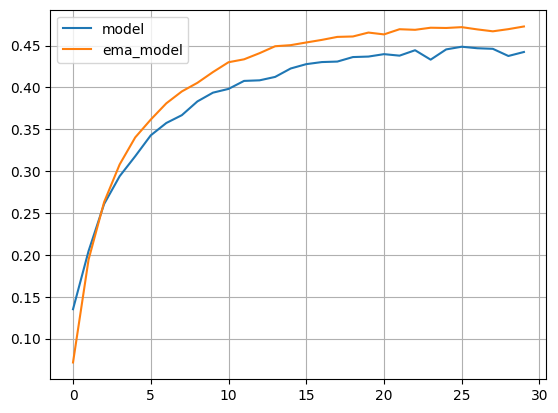

In [35]:
model = create_convnext_like_network(use_bn=True, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_droppath, val_metrics_droppath = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

If everything was implemented correctly, stochastic depth should give you +1-2% accuracy here comparing to the previous experiment (for single model and for averaged version of this model)

## 4.3 LabelSmooting

100%|██████████| 1563/1563 [01:39<00:00, 15.67it/s]


Epoch 1 of 30 took 109.691s
  training loss (in-iteration): 	4.804304
  validation accuracy: 			14.10 %
  validation accuracy(ema): 			8.11 %


100%|██████████| 1563/1563 [01:40<00:00, 15.60it/s]


Epoch 2 of 30 took 110.267s
  training loss (in-iteration): 	4.192836
  validation accuracy: 			21.55 %
  validation accuracy(ema): 			20.46 %


100%|██████████| 1563/1563 [01:39<00:00, 15.67it/s]


Epoch 3 of 30 took 109.828s
  training loss (in-iteration): 	3.907153
  validation accuracy: 			25.31 %
  validation accuracy(ema): 			26.49 %


100%|██████████| 1563/1563 [01:40<00:00, 15.60it/s]


Epoch 4 of 30 took 110.168s
  training loss (in-iteration): 	3.718443
  validation accuracy: 			28.90 %
  validation accuracy(ema): 			30.12 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 5 of 30 took 109.970s
  training loss (in-iteration): 	3.581971
  validation accuracy: 			31.87 %
  validation accuracy(ema): 			33.52 %


100%|██████████| 1563/1563 [01:40<00:00, 15.63it/s]


Epoch 6 of 30 took 110.072s
  training loss (in-iteration): 	3.469814
  validation accuracy: 			33.38 %
  validation accuracy(ema): 			35.80 %


100%|██████████| 1563/1563 [01:40<00:00, 15.61it/s]


Epoch 7 of 30 took 110.108s
  training loss (in-iteration): 	3.377029
  validation accuracy: 			34.71 %
  validation accuracy(ema): 			37.38 %


100%|██████████| 1563/1563 [01:38<00:00, 15.85it/s]


Epoch 8 of 30 took 108.645s
  training loss (in-iteration): 	3.296263
  validation accuracy: 			36.42 %
  validation accuracy(ema): 			38.88 %


100%|██████████| 1563/1563 [01:38<00:00, 15.86it/s]


Epoch 9 of 30 took 108.576s
  training loss (in-iteration): 	3.222922
  validation accuracy: 			37.43 %
  validation accuracy(ema): 			39.78 %


100%|██████████| 1563/1563 [01:39<00:00, 15.68it/s]


Epoch 10 of 30 took 109.638s
  training loss (in-iteration): 	3.159456
  validation accuracy: 			38.39 %
  validation accuracy(ema): 			40.81 %


100%|██████████| 1563/1563 [01:40<00:00, 15.53it/s]


Epoch 11 of 30 took 110.515s
  training loss (in-iteration): 	3.102274
  validation accuracy: 			40.01 %
  validation accuracy(ema): 			41.95 %


100%|██████████| 1563/1563 [01:39<00:00, 15.75it/s]


Epoch 12 of 30 took 109.055s
  training loss (in-iteration): 	3.050494
  validation accuracy: 			40.17 %
  validation accuracy(ema): 			43.16 %


100%|██████████| 1563/1563 [01:40<00:00, 15.57it/s]


Epoch 13 of 30 took 110.547s
  training loss (in-iteration): 	2.996629
  validation accuracy: 			40.63 %
  validation accuracy(ema): 			43.70 %


100%|██████████| 1563/1563 [01:40<00:00, 15.57it/s]


Epoch 14 of 30 took 110.357s
  training loss (in-iteration): 	2.955964
  validation accuracy: 			41.68 %
  validation accuracy(ema): 			44.40 %


100%|██████████| 1563/1563 [01:39<00:00, 15.67it/s]


Epoch 15 of 30 took 109.779s
  training loss (in-iteration): 	2.914091
  validation accuracy: 			42.30 %
  validation accuracy(ema): 			44.65 %


100%|██████████| 1563/1563 [01:39<00:00, 15.64it/s]


Epoch 16 of 30 took 109.947s
  training loss (in-iteration): 	2.875790
  validation accuracy: 			41.99 %
  validation accuracy(ema): 			44.93 %


100%|██████████| 1563/1563 [01:40<00:00, 15.53it/s]


Epoch 17 of 30 took 110.602s
  training loss (in-iteration): 	2.833688
  validation accuracy: 			42.89 %
  validation accuracy(ema): 			45.44 %


100%|██████████| 1563/1563 [01:40<00:00, 15.57it/s]


Epoch 18 of 30 took 110.406s
  training loss (in-iteration): 	2.798415
  validation accuracy: 			42.09 %
  validation accuracy(ema): 			45.64 %


100%|██████████| 1563/1563 [01:40<00:00, 15.62it/s]


Epoch 19 of 30 took 110.069s
  training loss (in-iteration): 	2.769835
  validation accuracy: 			43.68 %
  validation accuracy(ema): 			46.28 %


100%|██████████| 1563/1563 [01:38<00:00, 15.82it/s]


Epoch 20 of 30 took 108.864s
  training loss (in-iteration): 	2.739445
  validation accuracy: 			43.70 %
  validation accuracy(ema): 			46.37 %


100%|██████████| 1563/1563 [01:39<00:00, 15.75it/s]


Epoch 21 of 30 took 109.109s
  training loss (in-iteration): 	2.710600
  validation accuracy: 			44.20 %
  validation accuracy(ema): 			46.42 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 22 of 30 took 109.909s
  training loss (in-iteration): 	2.678750
  validation accuracy: 			44.15 %
  validation accuracy(ema): 			46.78 %


100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]


Epoch 23 of 30 took 109.885s
  training loss (in-iteration): 	2.653934
  validation accuracy: 			44.79 %
  validation accuracy(ema): 			47.01 %


100%|██████████| 1563/1563 [01:40<00:00, 15.56it/s]


Epoch 24 of 30 took 110.668s
  training loss (in-iteration): 	2.634644
  validation accuracy: 			45.11 %
  validation accuracy(ema): 			47.06 %


100%|██████████| 1563/1563 [01:40<00:00, 15.60it/s]


Epoch 25 of 30 took 110.329s
  training loss (in-iteration): 	2.604761
  validation accuracy: 			44.93 %
  validation accuracy(ema): 			46.91 %


100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


Epoch 26 of 30 took 108.962s
  training loss (in-iteration): 	2.581512
  validation accuracy: 			45.06 %
  validation accuracy(ema): 			47.42 %


100%|██████████| 1563/1563 [01:40<00:00, 15.61it/s]


Epoch 27 of 30 took 110.041s
  training loss (in-iteration): 	2.561598
  validation accuracy: 			44.80 %
  validation accuracy(ema): 			47.39 %


100%|██████████| 1563/1563 [01:39<00:00, 15.63it/s]


Epoch 28 of 30 took 110.040s
  training loss (in-iteration): 	2.538950
  validation accuracy: 			45.23 %
  validation accuracy(ema): 			47.22 %


100%|██████████| 1563/1563 [01:39<00:00, 15.63it/s]


Epoch 29 of 30 took 110.073s
  training loss (in-iteration): 	2.520295
  validation accuracy: 			45.49 %
  validation accuracy(ema): 			47.63 %


100%|██████████| 1563/1563 [01:39<00:00, 15.68it/s]


Epoch 30 of 30 took 109.685s
  training loss (in-iteration): 	2.505491
  validation accuracy: 			45.30 %
  validation accuracy(ema): 			47.70 %
Best model accuracy:  0.45491640127388533
Best ema model accuracy:  0.47701035031847133


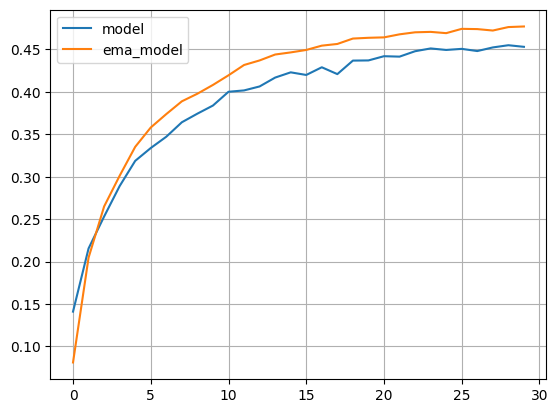

In [36]:
model = create_convnext_like_network(use_bn=True, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_ls, val_metrics_ls = train_loop(
    model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model, label_smoothing=0.1)

Label smoothing should slightly improve quality on ~0.1-0.5%. It should be easier to see on plots:

(0.35, 0.55)

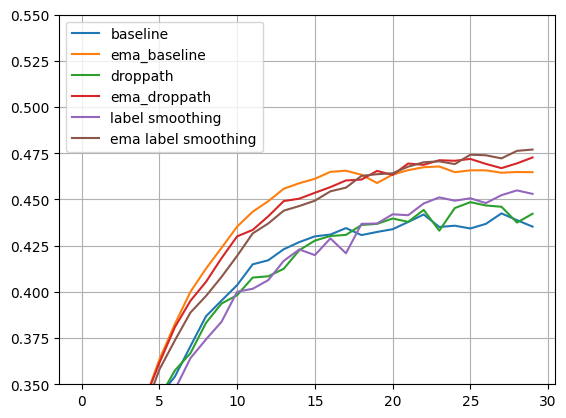

In [37]:
plt.plot(val_metrics_ema_bn['accuracy'], label='baseline')
plt.plot(val_metrics_ema_bn['ema_model_accuracy'], label='ema_baseline')
plt.plot(val_metrics_droppath['accuracy'], label='droppath')
plt.plot(val_metrics_droppath['ema_model_accuracy'], label='ema_droppath')
plt.plot(val_metrics_ls['accuracy'], label='label smoothing')
plt.plot(val_metrics_ls['ema_model_accuracy'], label='ema label smoothing')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.35, 0.55])

## 4.4 LayerNorm vs BatchNorm

100%|██████████| 1563/1563 [01:42<00:00, 15.20it/s]


Epoch 1 of 30 took 107.273s
  training loss (in-iteration): 	4.903094
  validation accuracy: 			7.78 %
  validation accuracy(ema): 			2.33 %


100%|██████████| 1563/1563 [01:41<00:00, 15.33it/s]


Epoch 2 of 30 took 106.364s
  training loss (in-iteration): 	4.280402
  validation accuracy: 			13.49 %
  validation accuracy(ema): 			10.40 %


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


Epoch 3 of 30 took 107.068s
  training loss (in-iteration): 	3.906489
  validation accuracy: 			18.32 %
  validation accuracy(ema): 			17.45 %


100%|██████████| 1563/1563 [01:41<00:00, 15.34it/s]


Epoch 4 of 30 took 106.330s
  training loss (in-iteration): 	3.659631
  validation accuracy: 			21.40 %
  validation accuracy(ema): 			22.53 %


100%|██████████| 1563/1563 [01:41<00:00, 15.36it/s]


Epoch 5 of 30 took 106.241s
  training loss (in-iteration): 	3.472430
  validation accuracy: 			25.03 %
  validation accuracy(ema): 			25.97 %


100%|██████████| 1563/1563 [01:43<00:00, 15.14it/s]


Epoch 6 of 30 took 107.684s
  training loss (in-iteration): 	3.304498
  validation accuracy: 			26.97 %
  validation accuracy(ema): 			28.91 %


100%|██████████| 1563/1563 [01:43<00:00, 15.05it/s]


Epoch 7 of 30 took 108.320s
  training loss (in-iteration): 	3.163919
  validation accuracy: 			30.30 %
  validation accuracy(ema): 			31.36 %


100%|██████████| 1563/1563 [01:43<00:00, 15.08it/s]


Epoch 8 of 30 took 108.143s
  training loss (in-iteration): 	3.037970
  validation accuracy: 			31.33 %
  validation accuracy(ema): 			33.51 %


100%|██████████| 1563/1563 [01:43<00:00, 15.04it/s]


Epoch 9 of 30 took 108.361s
  training loss (in-iteration): 	2.931314
  validation accuracy: 			32.91 %
  validation accuracy(ema): 			35.46 %


100%|██████████| 1563/1563 [01:43<00:00, 15.15it/s]


Epoch 10 of 30 took 107.622s
  training loss (in-iteration): 	2.834561
  validation accuracy: 			34.61 %
  validation accuracy(ema): 			36.98 %


100%|██████████| 1563/1563 [01:42<00:00, 15.18it/s]


Epoch 11 of 30 took 107.398s
  training loss (in-iteration): 	2.743095
  validation accuracy: 			35.39 %
  validation accuracy(ema): 			38.24 %


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch 12 of 30 took 107.181s
  training loss (in-iteration): 	2.658690
  validation accuracy: 			37.24 %
  validation accuracy(ema): 			39.36 %


100%|██████████| 1563/1563 [01:43<00:00, 15.03it/s]


Epoch 13 of 30 took 108.445s
  training loss (in-iteration): 	2.588493
  validation accuracy: 			37.92 %
  validation accuracy(ema): 			40.17 %


100%|██████████| 1563/1563 [01:43<00:00, 15.14it/s]


Epoch 14 of 30 took 107.675s
  training loss (in-iteration): 	2.512667
  validation accuracy: 			39.25 %
  validation accuracy(ema): 			41.38 %


100%|██████████| 1563/1563 [01:45<00:00, 14.79it/s]


Epoch 15 of 30 took 110.190s
  training loss (in-iteration): 	2.449548
  validation accuracy: 			39.41 %
  validation accuracy(ema): 			41.85 %


100%|██████████| 1563/1563 [01:46<00:00, 14.68it/s]


Epoch 16 of 30 took 110.968s
  training loss (in-iteration): 	2.386406
  validation accuracy: 			39.68 %
  validation accuracy(ema): 			42.56 %


100%|██████████| 1563/1563 [01:46<00:00, 14.67it/s]


Epoch 17 of 30 took 110.999s
  training loss (in-iteration): 	2.332097
  validation accuracy: 			40.16 %
  validation accuracy(ema): 			43.37 %


100%|██████████| 1563/1563 [01:45<00:00, 14.87it/s]


Epoch 18 of 30 took 109.583s
  training loss (in-iteration): 	2.271340
  validation accuracy: 			41.08 %
  validation accuracy(ema): 			43.85 %


100%|██████████| 1563/1563 [01:43<00:00, 15.11it/s]


Epoch 19 of 30 took 107.900s
  training loss (in-iteration): 	2.221097
  validation accuracy: 			41.89 %
  validation accuracy(ema): 			44.45 %


100%|██████████| 1563/1563 [01:42<00:00, 15.21it/s]


Epoch 20 of 30 took 107.233s
  training loss (in-iteration): 	2.170844
  validation accuracy: 			41.70 %
  validation accuracy(ema): 			44.64 %


100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s]


Epoch 21 of 30 took 107.548s
  training loss (in-iteration): 	2.125800
  validation accuracy: 			41.89 %
  validation accuracy(ema): 			44.98 %


100%|██████████| 1563/1563 [01:43<00:00, 15.07it/s]


Epoch 22 of 30 took 108.195s
  training loss (in-iteration): 	2.081018
  validation accuracy: 			42.64 %
  validation accuracy(ema): 			45.52 %


100%|██████████| 1563/1563 [01:43<00:00, 15.13it/s]


Epoch 23 of 30 took 107.711s
  training loss (in-iteration): 	2.041409
  validation accuracy: 			43.00 %
  validation accuracy(ema): 			45.25 %


100%|██████████| 1563/1563 [01:43<00:00, 15.12it/s]


Epoch 24 of 30 took 107.828s
  training loss (in-iteration): 	1.998399
  validation accuracy: 			43.08 %
  validation accuracy(ema): 			45.38 %


100%|██████████| 1563/1563 [01:43<00:00, 15.05it/s]


Epoch 25 of 30 took 108.285s
  training loss (in-iteration): 	1.960014
  validation accuracy: 			43.40 %
  validation accuracy(ema): 			45.58 %


100%|██████████| 1563/1563 [01:43<00:00, 15.06it/s]


Epoch 26 of 30 took 108.244s
  training loss (in-iteration): 	1.920038
  validation accuracy: 			43.30 %
  validation accuracy(ema): 			45.63 %


100%|██████████| 1563/1563 [01:43<00:00, 15.17it/s]


Epoch 27 of 30 took 107.475s
  training loss (in-iteration): 	1.881847
  validation accuracy: 			42.55 %
  validation accuracy(ema): 			45.75 %


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch 28 of 30 took 107.177s
  training loss (in-iteration): 	1.846959
  validation accuracy: 			43.00 %
  validation accuracy(ema): 			45.93 %


100%|██████████| 1563/1563 [01:43<00:00, 15.15it/s]


Epoch 29 of 30 took 107.578s
  training loss (in-iteration): 	1.814577
  validation accuracy: 			43.25 %
  validation accuracy(ema): 			45.60 %


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch 30 of 30 took 107.134s
  training loss (in-iteration): 	1.780726
  validation accuracy: 			42.82 %
  validation accuracy(ema): 			45.84 %
Best model accuracy:  0.43401671974522293
Best ema model accuracy:  0.4592953821656051


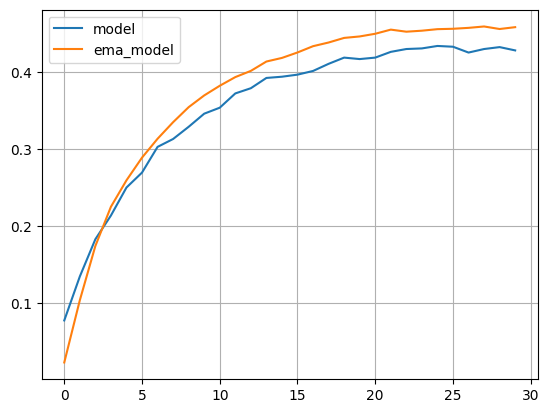

In [ ]:
model = create_convnext_like_network(use_bn=False, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_ln, val_metrics_ln = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

(0.35, 0.55)

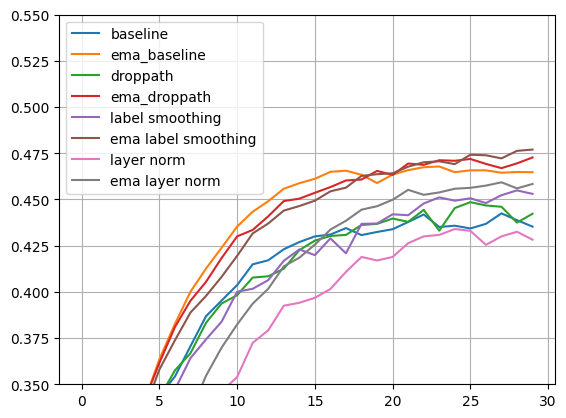

In [38]:
plt.plot(val_metrics_ema_bn['accuracy'], label='baseline')
plt.plot(val_metrics_ema_bn['ema_model_accuracy'], label='ema_baseline')
plt.plot(val_metrics_droppath['accuracy'], label='droppath')
plt.plot(val_metrics_droppath['ema_model_accuracy'], label='ema_droppath')
plt.plot(val_metrics_ls['accuracy'], label='label smoothing')
plt.plot(val_metrics_ls['ema_model_accuracy'], label='ema label smoothing')
plt.plot(val_metrics_ln['accuracy'], label='layer norm')
plt.plot(val_metrics_ln['ema_model_accuracy'], label='ema layer norm')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.35, 0.55])

With layer norm more likely you will see here a drop in accuracy on ~2% (or even more) comparing to the second experiment. But it doesn't mean that ConvNeXt authors were wrong on the replacing of batch norm with layer norm. Note that their training settings were different (batch size = 4k, multi-host training, larger dataset and model, longer training etc; see appendix A in the paper). There is more like an example that batch norm is still be usefull in 2020s in some tasks.

### What's next?
- We didn't used advanced augmentations (cutmix, randaugment etc) and some good stuff in optimization (AdamW, warm-up, cosine scheduler). But we will discuss it in seminar 3. See you there!
- We didn't check that stage ratio 1:1:3:1 really helps because we are limited by available hw for experiments. But feel free to play with architecture config if you have fast enough gpu.
- You may check ConvNeXt v2 architecture: "ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders" https://arxiv.org/abs/2301.00808

## References
- ConvNeXt architecture: "A ConvNet for the 2020s" https://arxiv.org/abs/2201.03545
- ConvNeXt implementation in pytorch: https://github.com/facebookresearch/ConvNeXt/tree/main
- LayerNorm: "Layer Normalization" https://arxiv.org/abs/1607.06450
- Model averaging: "Averaging Weights Leads to Wider Optima and Better Generalization" https://arxiv.org/abs/1803.05407
- Model averaging in pytorch: https://pytorch.org/docs/stable/optim.html#weight-averaging-swa-and-ema
- LayerScale: "Going deeper with Image Transformers" https://openaccess.thecvf.com/content/ICCV2021/papers/Touvron_Going_Deeper_With_Image_Transformers_ICCV_2021_paper.pdf
- Stochastic Depth: "Deep Networks with Stochastic Depth" https://arxiv.org/abs/1603.09382
- Label smooting: "Rethinking the Inception Architecture for Computer Vision" https://arxiv.org/abs/1512.00567
- Depth-wise separable convolutions: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications" https://arxiv.org/abs/1704.04861
- Inverted bottlenacks: "MobileNetV2: Inverted Residuals and Linear Bottlenecks" https://arxiv.org/abs/1801.04381
- New iteration on the architecture: "ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders" https://arxiv.org/abs/2301.00808